# Generate Images with StyleGAN

In [1]:
import os
import torch

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test torch in GPU
x = torch.randn((1, 1)).to(device)
print(2 * x)

/home/gregschuit/projects/Hammer/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0.1697]], device='cuda:0')


In [2]:
import sys
sys.path.append('../')

In [3]:
from pathlib import Path

import torch
from jupyter_compare_view import compare
from PIL import Image
from torchvision.transforms import ToPILImage, PILToTensor
from tqdm import tqdm

from models.stylegan2_generator import StyleGAN2Generator

to_pil_image = ToPILImage()
pil_to_tensor = PILToTensor()


Jupyter compare_view v0.2.1


In [4]:
v

In [13]:
paths = {
    'stylegan2_imagenome256_pa_resized': HAMMER_WORK_DIRS / 'stylegan2_imagenome256_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_device_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_device_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_lung_opacity_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_lung_opacity_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'c_stylegan2_imagenome256_atelectasis_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_atelectasis_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_pleural_effusion_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_pleural_effusion_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80/checkpoints/best-fid50k_full-checkpoint-070400.pth',
}


def load_generator(path):
    checkpoint = torch.load(path, map_location='cpu')
    init_kwargs = checkpoint['model_kwargs_init']['generator_smooth']
    del init_kwargs['model_type']
    model_kwargs_val = checkpoint['model_kwargs_val']['generator_smooth']
    generator = StyleGAN2Generator(**init_kwargs)
    generator.load_state_dict(checkpoint['models']['generator_smooth'])
    generator.eval()
    return generator, model_kwargs_val


def process_generated_tensor(img_tensor: torch.Tensor) -> Image:
    """Converts a generated image tensor to a PIL image.

    The image tensor is expected to be approx. in the range [-1, 1], as is the case
    with the StyleGAN2Generator output.

    Args:
        img_tensor (torch.Tensor): The image tensor to convert.

    Returns:
        PIL.Image: The converted image.

    """
    _min, _max = -1, 1
    img_tensor = torch.clamp(img_tensor, _min, _max)
    img_tensor = (img_tensor - _min) / (_max - _min)
    pil_image = to_pil_image(img_tensor)
    return pil_image


def generate_images(generator, label, batch_size, model_kwargs, device='cpu'):
    """Uses the generator to generate a batch of images.

    Args:
        generator (StyleGAN2Generator): The generator to use.
        label (List[int]): The label to use in one-hot encoding. This list will be 
            repeated to match the batch size.
        batch_size (int): The number of images to generate.
        model_kwargs (dict): The model kwargs to be passed to the model on inference.

    """
    codes = torch.randn((batch_size, 512)).to(device)
    labels = torch.tensor([label] * batch_size).to(device)
    with torch.no_grad():
        images = generator(codes, label=labels, **model_kwargs)['image']
    return images


def generate_images_with_same_noise(generator, batch_size, model_kwargs):

    codes = torch.randn((batch_size, 512))
    negative_labels = torch.tensor([[1, 0]] * batch_size)
    positive_labels = torch.tensor([[0, 1]] * batch_size)
    with torch.no_grad():
        negative_images = generator(codes, label=negative_labels, **model_kwargs)['image']
        positive_images = generator(codes, label=positive_labels, **model_kwargs)['image']
    return negative_images, positive_images


def show_batch(batch_images):
    w, h = 256, 256
    cols, rows = 3, len(batch_images) // 3 + (len(batch_images) % 3 > 0)
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img_tensor in enumerate(batch_images):
        img = process_generated_tensor(img_tensor)
        grid.paste(img, box=(i % cols * w, i // cols * h))

    return grid


def show_slider(img1, img2):
    """Displays interactive visualization using jupyter-compare-view library.

    Images should be equal size and can be PIL Images.

    """
    return compare(img1, img2, add_controls=True, start_mode="vertical", start_slider_pos=0.73)


## Conditioned on Atelectasis


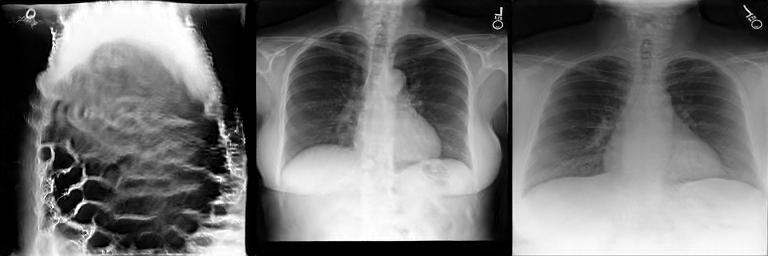
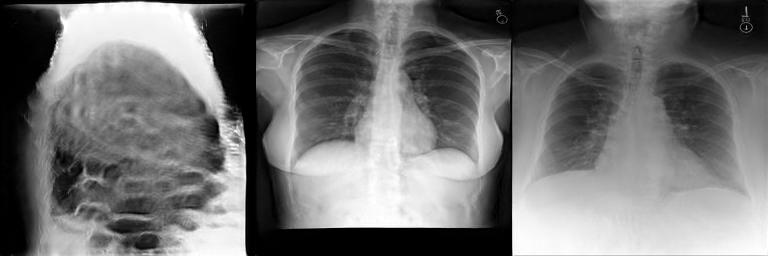

In [10]:
path = paths['c_stylegan2_imagenome256_atelectasis_pa_resized']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

show_batch(torch.cat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))

## Conditioned on Lung Opacity


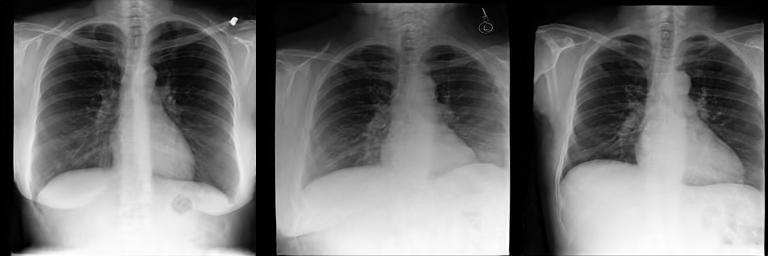
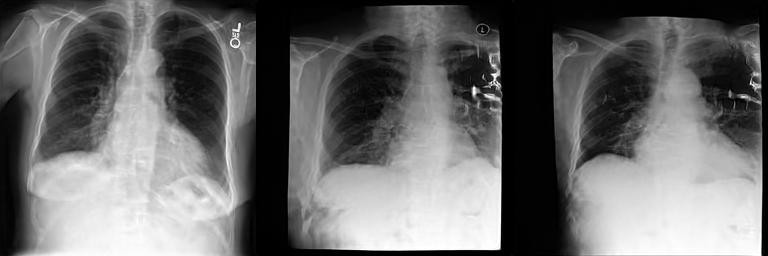

In [11]:
path = paths['c_stylegan2_imagenome256_lung_opacity_pa_resized']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

# show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))

## Conditioned on Enlarged Cardiac Silhouette


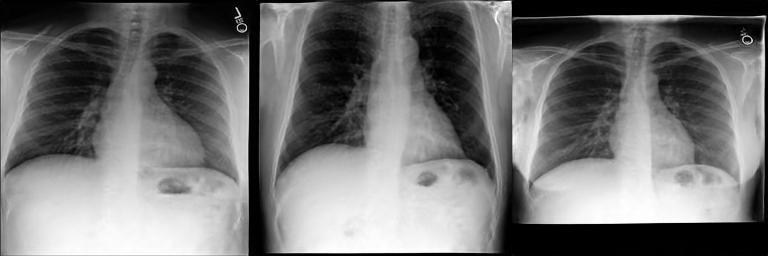
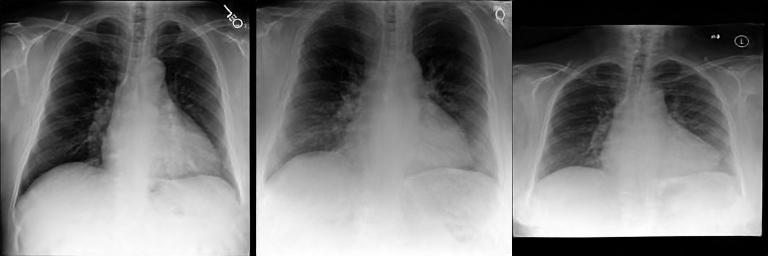

In [14]:
path = paths['c_stylegan2_imagenome256_enlarged_cardiac_pa_resized']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

# show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))


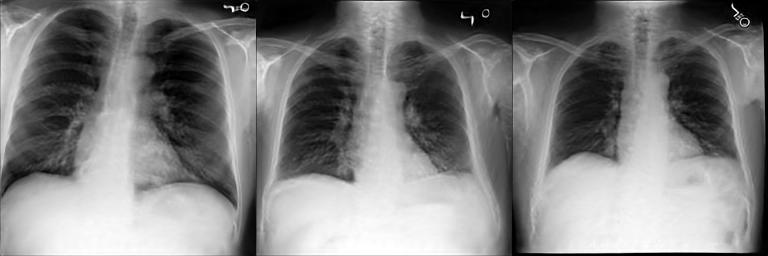
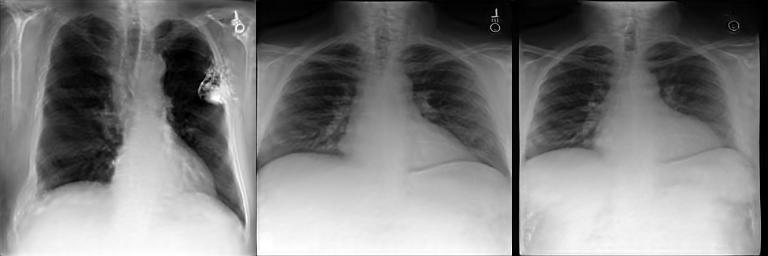

In [15]:
path = paths['r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

# show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))


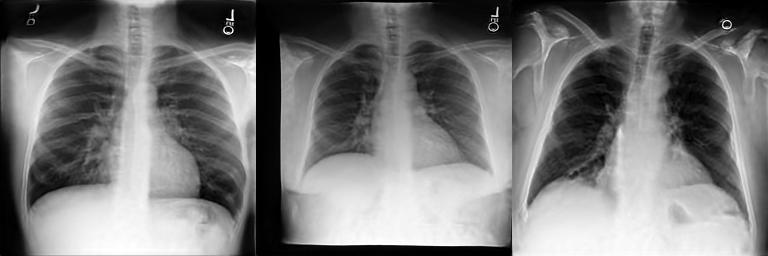
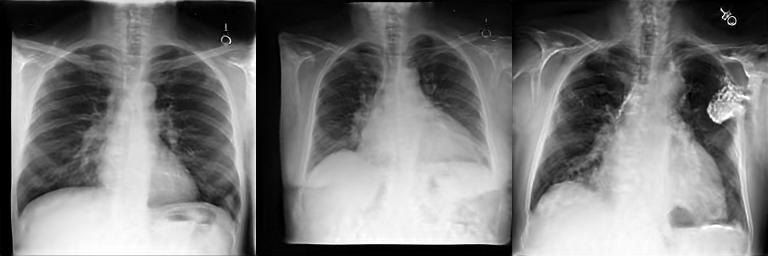

In [8]:
path = paths['r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

# show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))


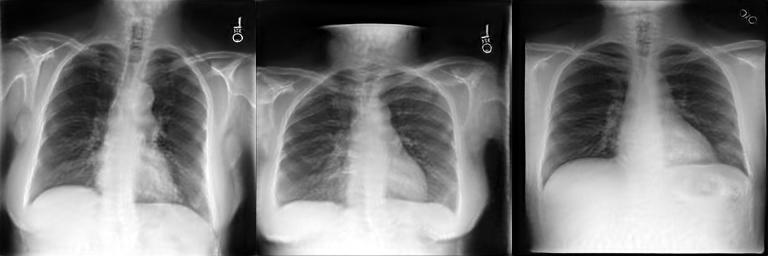
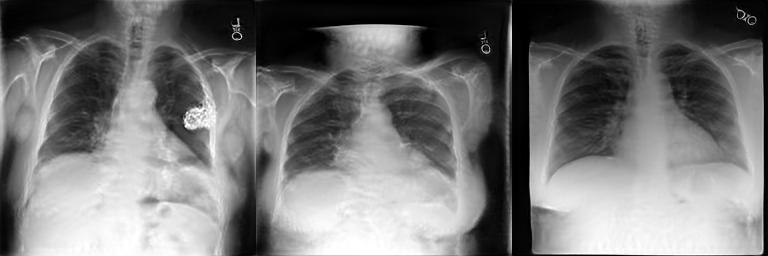

In [9]:
path = paths['r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

# show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))

## Conditioned on Pleural Effusion


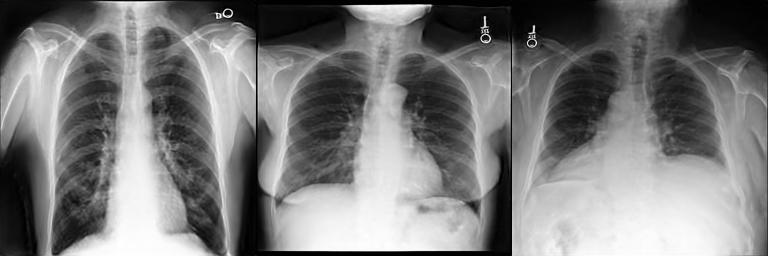
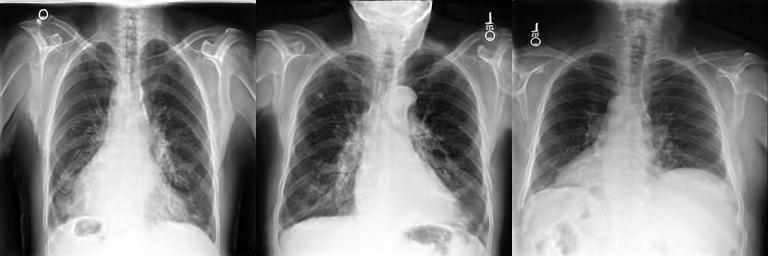

In [9]:
path = paths['c_stylegan2_imagenome256_pleural_effusion_pa_resized']
generator, model_kwargs = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

# show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))

## Generate and save several images

In [16]:
def get_last_id(dir):
    ids = [int(file_name.split('.')[0]) for file_name in os.listdir(dir)]
    return max(ids) if ids else 0


def save_batch(batch_images, dir, last_id: int = -1):
    for i, img in enumerate(batch_images):
        img = process_generated_tensor(img)
        id = last_id + i + 1
        id_str = str(id).zfill(6)
        img.save(os.path.join(dir, f'{id_str}.png'))

In [15]:
DATA_DIR = '../.data/synthetic'

In [16]:
def create_destiny_dir(destiny_dir: str):
    if os.path.exists(destiny_dir):
        raise ValueError(f'Folder {destiny_dir} already exists')
    else:
        os.mkdir(destiny_dir)


def finding_name_to_snake_case(finding_name: str):
    """Take the first two words and then join them with an underscore

    Also, make it lowercase.

    For example:

    >>> finding_name_to_snake_case('Enlarged Cardiac Silhouette')
    'enlarged_cardiac'

    """
    return '_'.join(finding_name.split(' ')[:2]).lower()


def generate_conditioned(
    model_name: str,
    finding_name: str,
    batch_size: int,
    total_imgs: int,
    device: str = 'cpu',
    prefix: str = 'c_stylegan2_imagenome_',
    suffix: str = '',
) -> None:

    # Create destiny folder
    finding_as_snake = finding_name_to_snake_case(finding_name)
    finding_dir = os.path.join(DATA_DIR, f'{prefix}{finding_as_snake}{suffix}')
    negative_dir = os.path.join(finding_dir, '0')
    positive_dir = os.path.join(finding_dir, '1')
    create_destiny_dir(finding_dir)
    create_destiny_dir(negative_dir)
    create_destiny_dir(positive_dir)

    # Generate images
    generator, model_kwargs = load_generator(paths[model_name])
    generator = generator.to(device)
    for i in tqdm(range(0, total_imgs, batch_size)):
        # negative generation
        label_vector = [1, 0]
        batch_images = generate_images(
            generator, label_vector, batch_size, model_kwargs, device
        )
        save_batch(batch_images, negative_dir, last_id=i - 1)

        # positive generation
        label_vector = [0, 1]
        batch_images = generate_images(
            generator, label_vector, batch_size, model_kwargs, device
        )
        save_batch(batch_images, positive_dir, last_id=i - 1)

    print(f'Generated and saved {total_imgs} negative images in {negative_dir}')
    print(f'Generated and saved {total_imgs} positive images in {positive_dir}')


In [18]:
generate_conditioned(
    model_name='c_stylegan2_imagenome256_atelectasis_pa_resized',
    finding_name='Atelectasis',
    batch_size=8,
    total_imgs=30_000,
    device=device,
)

100%|██████████| 3750/3750 [25:05<00:00,  2.49it/s]

Generated and saved 30000 negative images in /home/gregschuit/projects/cxr-data/synthetic/c_stylegan2_imagenome_atelectasis/0
Generated and saved 30000 positive images in /home/gregschuit/projects/cxr-data/synthetic/c_stylegan2_imagenome_atelectasis/1


In [18]:
generate_conditioned(
    model_name='r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80',
    finding_name='Enlarged Cardiac Silhouette',
    batch_size=25,
    total_imgs=30_000,
    device=device,
    prefix='r_c_stylegan2_imagenome_w80_',
)

100%|██████████| 1200/1200 [24:44<00:00,  1.24s/it]

Generated and saved 30000 negative images in ../.data/synthetic/r_c_stylegan2_imagenome_w80_enlarged_cardiac/0
Generated and saved 30000 positive images in ../.data/synthetic/r_c_stylegan2_imagenome_w80_enlarged_cardiac/1


In [20]:
generate_conditioned(
    model_name='c_stylegan2_imagenome256_lung_opacity_pa_resized',
    finding_name='Lung Opacity',
    batch_size=8,
    total_imgs=30_000,
    device=device,
)

100%|██████████| 3750/3750 [24:50<00:00,  2.52it/s]

Generated and saved 30000 negative images in /home/gregschuit/projects/cxr-data/synthetic/c_stylegan2_imagenome_lung_opacity/0
Generated and saved 30000 positive images in /home/gregschuit/projects/cxr-data/synthetic/c_stylegan2_imagenome_lung_opacity/1


In [13]:
generate_conditioned(
    model_name='c_stylegan2_imagenome256_pleural_effusion_pa_resized',
    finding_name='Pleural Effusion',
    batch_size=8,
    total_imgs=30_000,
    device=device,
)

100%|██████████| 3750/3750 [29:03<00:00,  2.15it/s]

Generated and saved 30000 negative images in /home/gregschuit/projects/cxr-data/synthetic/c_stylegan2_imagenome_pleural_effusion/0
Generated and saved 30000 positive images in /home/gregschuit/projects/cxr-data/synthetic/c_stylegan2_imagenome_pleural_effusion/1
